# Reference

https://github.com/rafaelanchieta/essay

https://research.google.com/colaboratory/local-runtimes.html

# Approach

## Strategy 1


Feed the Neural Networks with the Essays, use NN for Regression, trying to
predict the final grade

## Strategy 2

Manually correct some essay competences, feed the NN with the essays, use NN for Regression, trying to predict the final grade without the competences that were manually corrected, then add the grade of the competences manually corrected

## Strategy 3

Feed the NN with the Essays, use NN for Classification with 10 classes, [0-100], [101-200], ..., [901-1000] scores.

## Strategy 4

Feed the NN with the Essays, use NN for Classification with 2 classes 0 and 1

# Upload the dataset

In [ ]:
!cp -r /content/drive/MyDrive/TCC/* .

# Installing Libraries


In [ ]:
!pip install datasets evaluate transformers[sentencepiece]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 58.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 68.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 60.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 30.2 MB/s eta 0:00:00


# Imports

In [ ]:
from datasets import Dataset

In [ ]:
from build_dataset import Corpus
import tensorflow as tf
from tensorflow import keras
from transformers import AutoTokenizer, DataCollatorWithPadding, TFAutoModelForSequenceClassification
from transformers.models.auto.modeling_tf_auto import TFAutoModelForPreTraining
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.optimizers import Adam
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics         import mean_absolute_error, mean_squared_error, cohen_kappa_score
#sklearn.metrics.cohen_kappa_score
import pandas as pd
from tensorflow.keras.layers import Input, Dropout, Dense
from transformers import TFAutoModel
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

###--------- ESTILIZAÇÃO DO NOTEBOOK ---------###

from IPython.core.display import display, HTML

# retira a margem do notebook
display(HTML("<style>.container { width:100% !important; }</style>"))

# tamanho da fonte do texto markdown
display(HTML("<style>h1 { font-size:23px !important; }</style>"))
display(HTML("<style>h2 { font-size:20px !important; }</style>"))
display(HTML("<style>h3 { font-size:17px !important; }</style>"))
display(HTML("<style>h4 { font-size:16px !important; }</style>"))
display(HTML("<style>p { font-size:16px !important; }</style>"))

# tamanho da fonte da tabela
display(HTML("<style>th { font-size:15px !important; }</style>"))
display(HTML("<style>td { font-size:15px !important; }</style>"))

# tamanho da fonte do codigo
display(HTML("<style>span { font-size:16px !important; }</style>"))

# Loading Data

In [ ]:
c = Corpus()
c.read_corpus()
all_data = c.read_corpus()

In [ ]:
all_data

,prompt,title,essay,competence,score
0,21,A greve dos caminhoneiros e a malha ferroviária,[A grande importância dos caminhoneiros para o...,"[160, 160, 120, 120, 120]",680
1,23,"Vossa excelência Senador M. M.,",[O senhor e eu já estamos cientes do projeto d...,"[160, 160, 120, 120, 120]",680
2,39,A validade do impeachment,[É de conhecimento geral dos brasileiros o quã...,"[120, 160, 160, 160, 120]",720
3,26,Podemos perceber que a sociedade brasileira,[Podemos perceber que a sociedade brasileira e...,"[120, 120, 80, 120, 120]",560
4,4,Comenta-se que o ex-presidente Lula,[Comenta-se que o ex presidente Lula ex-presid...,"[0, 0, 0, 0, 0]",0
...,...,...,...,...,...
4565,43,redes sociais,"[Em constante evolução tecnológica , o mundo e...","[160, 120, 120, 120, 120]",640
4566,60,Reforma da Previdência uma solução para o Brasil.,"[“O importante da vida não é viver, mas viver ...","[120, 80, 80, 120, 80]",480
4567,44,"lados opostos, mesmo problema",[O esporte – seja qual for – é comporto por re...,"[160, 200, 160, 200, 200]",920
4568,49,Da Ficção à Realidade,"[José Saramago, proeminente escritor e dramatu...","[160, 160, 160, 160, 160]",800


In [ ]:
def load_data():
    # Read Corpus
    c = Corpus()
    c.read_corpus()
    # Create splits from Corpus
    #print(f"Corpus shape: {c.shape}")

    train, valid, test = c.read_splits()

    print(f"Train shape: {train.shape}")
    print(f"Validation shape: {valid.shape}")
    print(f"Test shape: {test.shape}")

    return train, valid, test

# Data Analysis

In [ ]:
train, valid, test = load_data()
df = train

Train shape: (3198, 5)
Validation shape: (686, 5)
Test shape: (686, 5)


In [ ]:
df['essay'][1]

['Pode -se afirmar que a presença dos Jesuítas, trouxe a aprendizagem, assim sendo à alfabetização dos índios . Atualmente a educação, ocorre em ensino regular, embora muitos chegam ao ensino superior incapazes de interpretar textos e cálculos matemáticos.',
 'Em primeiro lugar Padre Antônio Vieira`` A boa educação é a moeda de Ouro. Em toda parte, tem valor, ´sabe- que a precariedade educacional, levam os discentes a não interagir com a leitura, entretanto muitos docentes preocupam em cumprir os currículos e levam adiante a negligência.',
 'Em segundo lugar os recursos de tecnologia,\xa0 não utilizados de forma eficaz levam aos cidadãos à lentidão ao analfabetismo funcional , entretanto está ineficiência deixa as políticas econômicas a repensar sobre as necessidades.',
 'Por fim, segundo o IBG Instituto Brasileiro Geográfico este número de pessoas sem instrução formal tem sido diminuindo em XXI, por outro lado a população estão adquirindo seus conhecimentos em uma democracia da socied

In [ ]:
df

,prompt,title,essay,competence,score
0,60,Reforma da previdência,[É notório que a reforma da previdência no Bra...,"[120, 80, 80, 120, 40]",440
1,51,ANALFABETISMO E SOCIEDADE,"[Pode -se afirmar que a presença dos Jesuítas,...","[120, 120, 80, 80, 80]",480
2,73,Caminhos para superar os desafios encontrados ...,[Em 13 de maio de 1888 veio ao Brasil a lei da...,"[120, 80, 80, 80, 80]",440
3,51,Analfabetismo funcional no Brasil tem solução.,[“Uma sociedade só progride quando um se mobil...,"[120, 160, 120, 120, 120]",640
4,59,NaN,"[Nas últimas décadas, o Brasil vem enfrentando...","[120, 120, 80, 120, 120]",560
...,...,...,...,...,...
3193,49,O papel dos Influenciadores digitais,[Atualmente a influência que a mídia proporcio...,"[120, 80, 80, 80, 0]",360
3194,73,O tempo não cura tudo.,[É mais fácil desintegrar um átomo do que um p...,"[120, 160, 120, 120, 120]",640
3195,69,NaN,[É indiscutível que o uso de agrotóxicos no Br...,"[120, 120, 120, 120, 120]",600
3196,59,Crise Econômica e Corrupção,[De acordo com o relatório internacional divul...,"[120, 160, 120, 160, 120]",680


## Essays Length

In [ ]:
# Join all the paragraphs of an essay in a same string
aux = df['essay'].map( lambda x : ''.join(x))
length_array = aux.map(lambda x: len(x))

In [ ]:
print(f"The essays length mean is: {np.mean( length_array )}")
print(f"The essays length median is: {np.median( length_array )}")
print(f"The minimum essays length is: {np.min( length_array )}")
print(f"The maximum essays length is: {np.max( length_array )}")

The essays length mean is: 1819.8055034396498
The essays length median is: 1804.0
The minimum essays length is: 497
The maximum essays length is: 5109


Text(0, 0.5, 'Frequência')

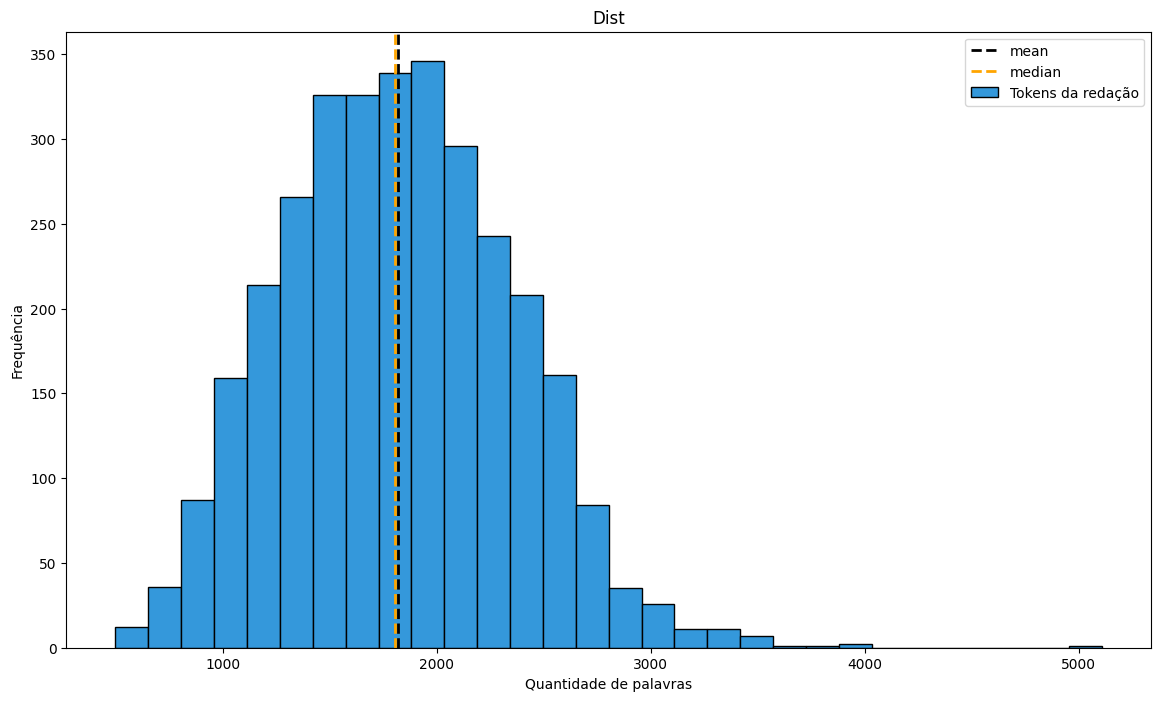

In [ ]:
plt.figure(figsize=(14, 8))

# mean in Red
plt.axvline(x=np.mean(length_array), ymin=0, ymax=1, label='mean', color='black', linestyle='dashed', linewidth=2,)
# median in Green
plt.axvline(x=np.median(length_array), ymin=0, ymax=1, label='median', color='orange', linestyle='dashed', linewidth=2,)

plt.hist(length_array, bins=30, color='#3498DB', edgecolor='black', label='Tokens da redação')
plt.legend()
plt.title("Dist")
plt.xlabel('Quantidade de palavras')
plt.ylabel('Frequência')
#sns.distplot( length_array );


## Grades Distribution

In [ ]:
aux = df.copy()


In [ ]:
[ (i*40) for i in range(1000//40 + 1) ]

[0,
 40,
 80,
 120,
 160,
 200,
 240,
 280,
 320,
 360,
 400,
 440,
 480,
 520,
 560,
 600,
 640,
 680,
 720,
 760,
 800,
 840,
 880,
 920,
 960,
 1000]

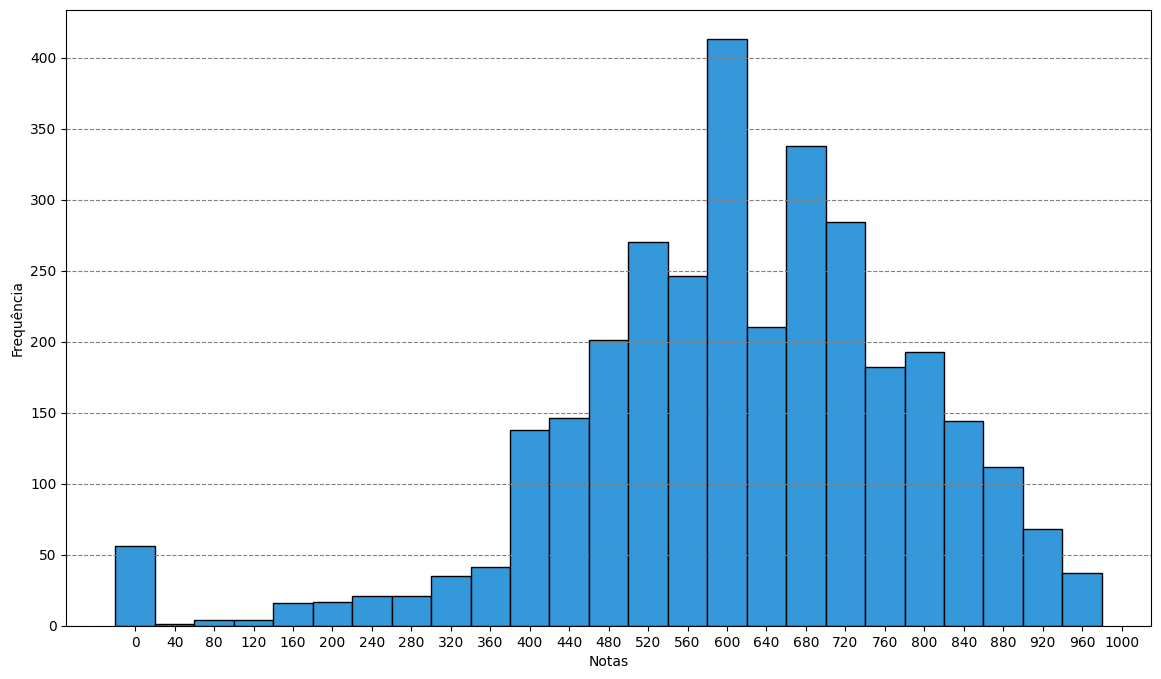

In [ ]:
#plt.figure(figsize=(10, 6))

# mean in Red
#plt.axvline(x=np.mean(length_array), ymin=0, ymax=1, label='mean', color='r')
# median in Green
#plt.axvline(x=np.median(length_array), ymin=0, ymax=1, label='median', color='g')


plt.figure(figsize=(14, 8))

#intervals = [0,120,240,360,480,600,720,840,1000 ]
intervals = [ (i*40) for i in range(1000//40 + 1) ]
plt.hist(aux["score"], bins=intervals, color='#3498DB', edgecolor='black')
#bin_midpoints = 0.5 * (intervals[:-1] + intervals[1:])
plt.xticks([i+20 for i in intervals], intervals)


plt.xlabel('Notas')
plt.ylabel('Frequência')
plt.grid(axis='y', linestyle='--', color='gray')

# mean in Red
#plt.axvline(x=np.mean(length_array), ymin=0, ymax=1, label='mean', color='black', linestyle='dashed', linewidth=2,)
# median in Green
#plt.axvline(x=np.median(length_array), ymin=0, ymax=1, label='median', color='orange', linestyle='dashed', linewidth=2,)


#plt.legend()
#plt.title("Grades Distribution")

#plt.xticklabels(intervals)

#sns.distplot( length_array );


# The bins are [ , )
#ax = sns.histplot(data=aux, x="score", bins=intervals)


#sns.distplot( aux['score'] );


### Grades Distribution

### Total Corpus

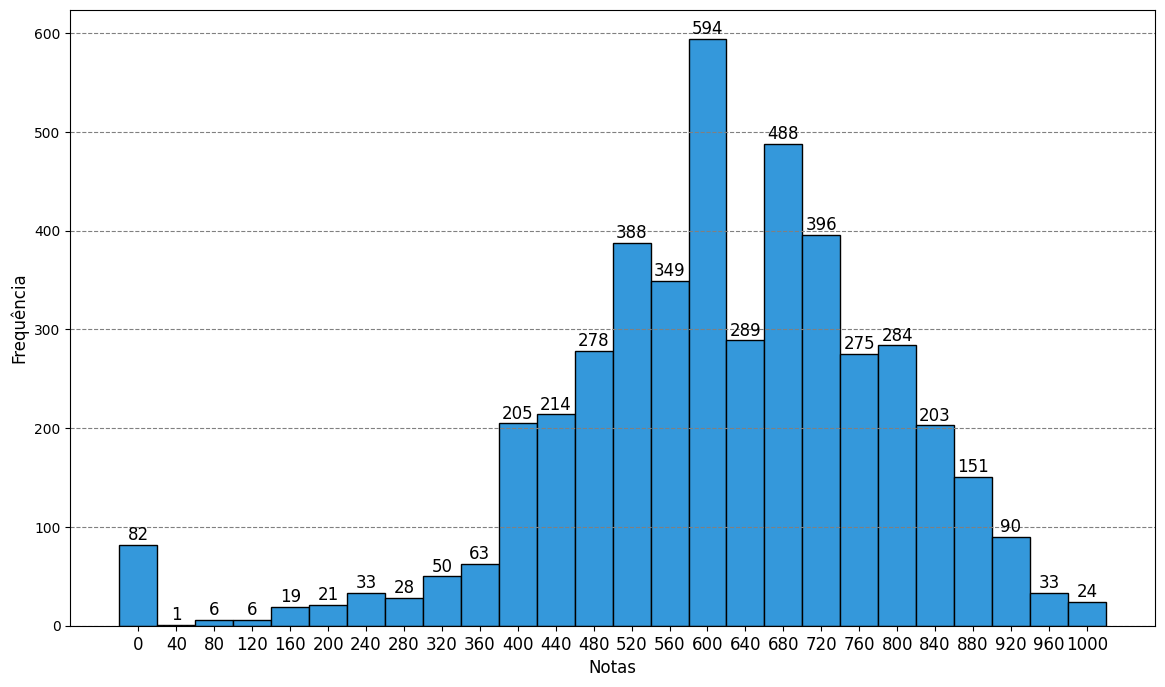

In [ ]:
plt.figure(figsize=(14, 8))

#intervals = [0,120,240,360,480,600,720,840,1000 ]
intervals = [ (i*40) for i in range(1080//40) ]
n, bins, patches = plt.hist(all_data["score"], bins=intervals, color='#3498DB', edgecolor='black')
#bin_midpoints = 0.5 * (intervals[:-1] + intervals[1:])
plt.xticks([i+20 for i in intervals[:-1]], intervals[:-1], fontsize=12)

for count, bin_start, patch in zip(n, bins[:-1], patches):
    plt.text(bin_start + (bins[1] - bins[0]) / 2, count + 1, str(int(count)), ha='center', va='bottom', fontsize=12)

plt.xlabel('Notas', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.grid(axis='y', linestyle='--', color='gray')

plt.savefig('grades_distribution.png', format='png', dpi=300)


### Train

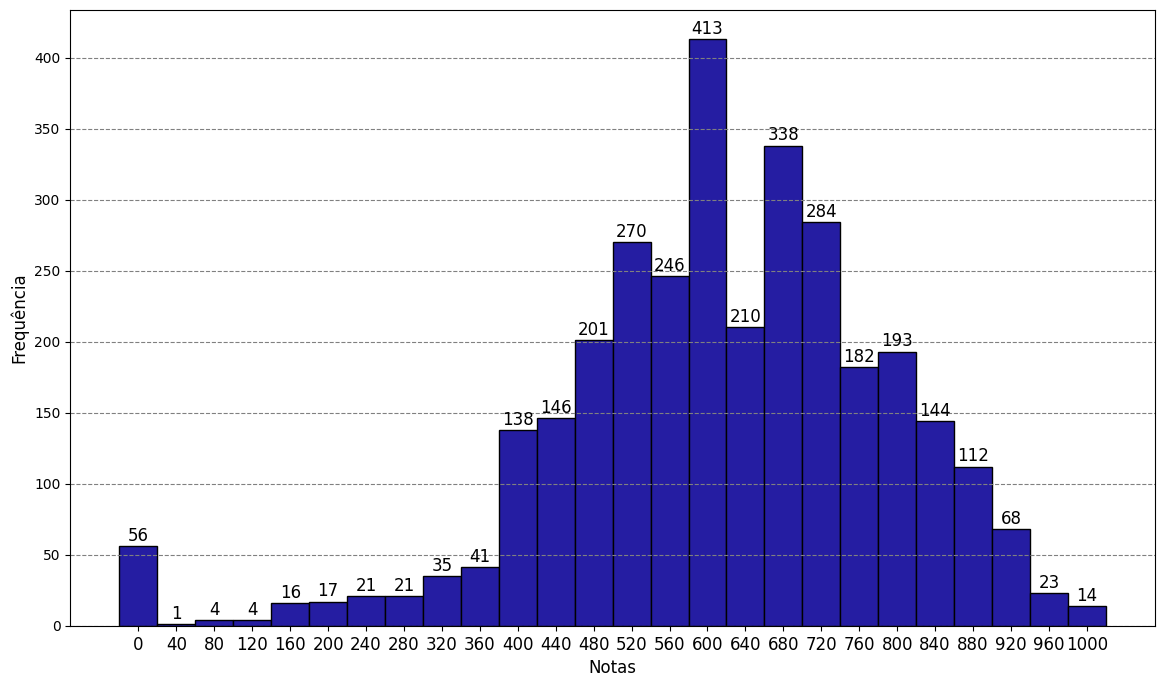

In [ ]:
plt.figure(figsize=(14, 8))

#intervals = [0,120,240,360,480,600,720,840,1000 ]
intervals = [ (i*40) for i in range(1080//40) ]
n, bins, patches = plt.hist(train["score"], bins=intervals, color='#251da2', edgecolor='black')
#bin_midpoints = 0.5 * (intervals[:-1] + intervals[1:])
plt.xticks([i+20 for i in intervals[:-1]], intervals[:-1], fontsize=12)

for count, bin_start, patch in zip(n, bins[:-1], patches):
    plt.text(bin_start + (bins[1] - bins[0]) / 2, count + 1, str(int(count)), ha='center', va='bottom', fontsize=12)

plt.xlabel('Notas', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.grid(axis='y', linestyle='--', color='gray')

plt.savefig('grades_distribution_train.png', format='png', dpi=300)


### Validation

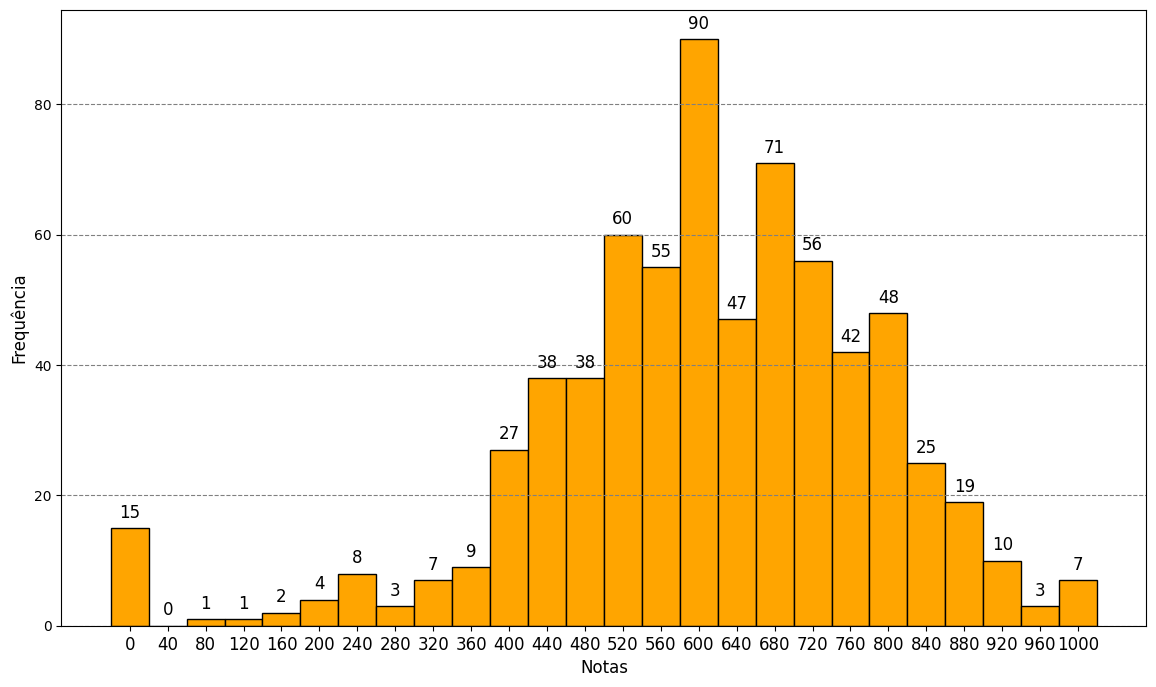

In [ ]:
plt.figure(figsize=(14, 8))

#intervals = [0,120,240,360,480,600,720,840,1000 ]
intervals = [ (i*40) for i in range(1080//40) ]
n, bins, patches = plt.hist(valid["score"], bins=intervals, color='#ffa500', edgecolor='black')
#bin_midpoints = 0.5 * (intervals[:-1] + intervals[1:])
plt.xticks([i+20 for i in intervals[:-1]], intervals[:-1], fontsize=12)

for count, bin_start, patch in zip(n, bins[:-1], patches):
    plt.text(bin_start + (bins[1] - bins[0]) / 2, count + 1, str(int(count)), ha='center', va='bottom', fontsize=12)

plt.xlabel('Notas', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.grid(axis='y', linestyle='--', color='gray')

plt.savefig('grades_distribution_valid.png', format='png', dpi=300)


### Test

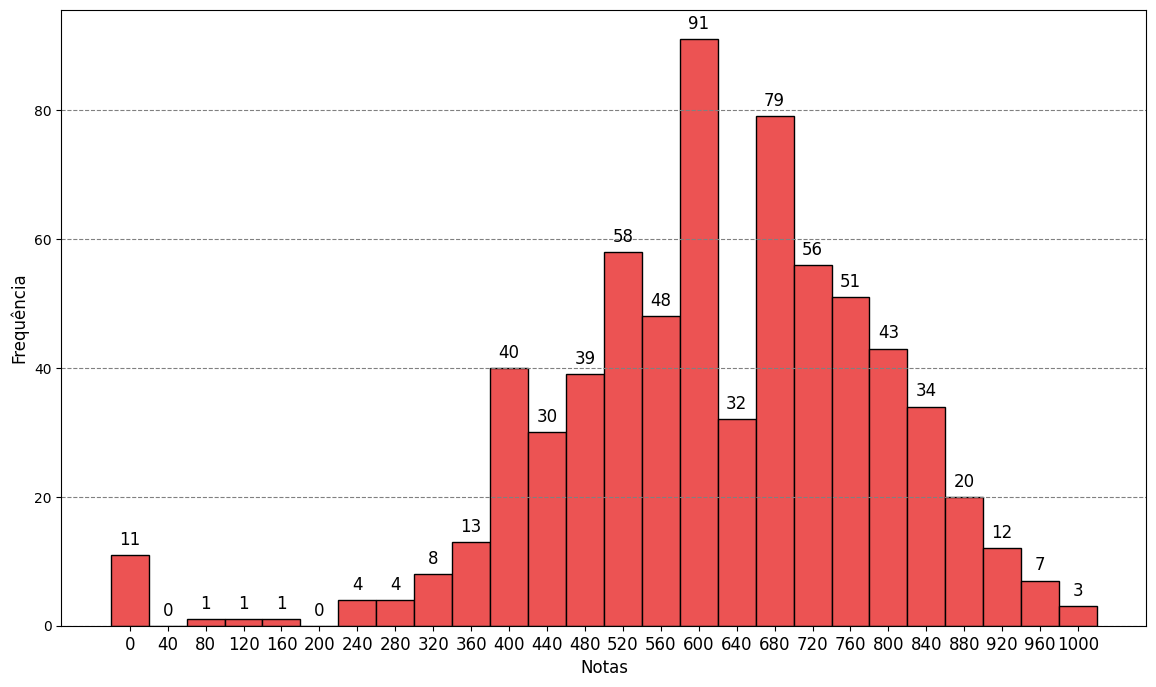

In [ ]:
plt.figure(figsize=(14, 8))

#intervals = [0,120,240,360,480,600,720,840,1000 ]
intervals = [ (i*40) for i in range(1080//40) ]
n, bins, patches = plt.hist(test["score"], bins=intervals, color='#ec5353', edgecolor='black')
#bin_midpoints = 0.5 * (intervals[:-1] + intervals[1:])
plt.xticks([i+20 for i in intervals[:-1]], intervals[:-1], fontsize=12)

for count, bin_start, patch in zip(n, bins[:-1], patches):
    plt.text(bin_start + (bins[1] - bins[0]) / 2, count + 1, str(int(count)), ha='center', va='bottom', fontsize=12)

plt.xlabel('Notas', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.grid(axis='y', linestyle='--', color='gray')

plt.savefig('grades_distribution_test.png', format='png', dpi=300)


In [ ]:
aux.shape

(3198, 5)

## Grades Tercile

In [ ]:
aux.score.quantile(q=0.33)

560.0

In [ ]:
aux.score.quantile(q=0.66)

680.0

In [ ]:
aux[ (aux['score'] >= 0) & (aux['score'] <= 560) ].shape

(1217, 5)

In [ ]:
aux[ (aux['score'] > 560) & (aux['score'] <= 680) ].shape

(961, 5)

In [ ]:
aux[ (aux['score'] > 680) & (aux['score'] <= 1000) ].shape

(1020, 5)

### Grades Quartile

In [ ]:
aux.score.quantile(q=0.25)

520.0

In [ ]:
aux.score.quantile(q=0.50)

600.0

In [ ]:
aux.score.quantile(q=0.75)

720.0

In [ ]:
aux[ (aux['score'] >= 0) & (aux['score'] < 520) ].shape

(701, 5)

In [ ]:
aux[ (aux['score'] >= 520) & (aux['score'] <= 600) ].shape

(929, 5)

In [ ]:
aux[ (aux['score'] > 600) & (aux['score'] <= 720) ].shape

(832, 5)

In [ ]:
aux[ (aux['score'] > 720) & (aux['score'] <= 1000) ].shape

(736, 5)

### Grades Quintile

In [ ]:
aux.score.quantile(q=0.2)

480.0

In [ ]:
aux.score.quantile(q=0.4)

600.0

In [ ]:
aux.score.quantile(q=0.6)

680.0

In [ ]:
aux.score.quantile(q=0.8)

760.0

In [ ]:
aux[ (aux['score'] >= 0) & (aux['score'] < 480) ].shape

(500, 5)

In [ ]:
aux[ (aux['score'] >= 480) & (aux['score'] <= 600) ].shape

(1130, 5)

In [ ]:
aux[ (aux['score'] > 600) & (aux['score'] <= 680) ].shape

(548, 5)

In [ ]:
aux[ (aux['score'] > 680) & (aux['score'] <= 760) ].shape

(466, 5)

In [ ]:
aux[ (aux['score'] > 760) & (aux['score'] <= 1000) ].shape

(554, 5)

In [ ]:
aux[ (aux['score'] >= 0) & (aux['score'] < 500) ].shape

(701, 5)

In [ ]:
aux[ aux['score'] >= 500 ].shape

(2497, 5)

In [ ]:
aux[ (aux['score'] >= 500) & (aux['score'] < 700) ].shape

(1477, 5)

In [ ]:
aux[ (aux['score'] >= 700) & (aux['score'] < 1001) ].shape

(1020, 5)

## Competences distribution

In [ ]:
all_data["c1"] = all_data["competence"].apply(lambda x: x[0])
all_data["c2"] = all_data["competence"].apply(lambda x: x[1])
all_data["c3"] = all_data["competence"].apply(lambda x: x[2])
all_data["c4"] = all_data["competence"].apply(lambda x: x[3])
all_data["c5"] = all_data["competence"].apply(lambda x: x[4])

In [ ]:
all_data.groupby("c1").count()["score"] / all_data.shape[0]

c1
0      0.021225
40     0.005252
80     0.078556
120    0.575492
160    0.292779
200    0.026696
Name: score, dtype: float64

In [ ]:
all_data.groupby("c2").count()["score"] / all_data.shape[0]

c2
0      0.023851
40     0.017287
80     0.150766
120    0.374398
160    0.373085
200    0.060613
Name: score, dtype: float64

In [ ]:
all_data.groupby("c3").count()["score"] / all_data.shape[0]

c3
0      0.026696
40     0.031947
80     0.263895
120    0.466083
160    0.180963
200    0.030416
Name: score, dtype: float64

In [ ]:
all_data.groupby("c4").count()["score"] / all_data.shape[0]

c4
0      0.029322
40     0.013348
80     0.129103
120    0.437637
160    0.271554
200    0.119037
Name: score, dtype: float64

In [ ]:
all_data.groupby("c5").count()["score"] / all_data.shape[0]

c5
0      0.066083
40     0.060394
80     0.223851
120    0.378993
160    0.178337
200    0.092341
Name: score, dtype: float64

In [ ]:
all_data.groupby("c1").count()["score"]

c1
0        97
40       24
80      359
120    2630
160    1338
200     122
Name: score, dtype: int64

In [ ]:
all_data.groupby("c2").count()["score"]

c2
0       109
40       79
80      689
120    1711
160    1705
200     277
Name: score, dtype: int64

In [ ]:
all_data.groupby("c3").count()["score"]

c3
0       122
40      146
80     1206
120    2130
160     827
200     139
Name: score, dtype: int64

In [ ]:
all_data.groupby("c4").count()["score"]

c4
0       134
40       61
80      590
120    2000
160    1241
200     544
Name: score, dtype: int64

In [ ]:
all_data.groupby("c5").count()["score"]

c5
0       302
40      276
80     1023
120    1732
160     815
200     422
Name: score, dtype: int64

In [ ]:
aux = df.copy()

In [ ]:
aux['competence_1'] = aux['competence'].apply(lambda x: x[0])
aux['competence_2'] = aux['competence'].apply(lambda x: x[1])
aux['competence_3'] = aux['competence'].apply(lambda x: x[2])
aux['competence_4'] = aux['competence'].apply(lambda x: x[3])
aux['competence_5'] = aux['competence'].apply(lambda x: x[4])

<ipython-input-42-868b9170d014>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( aux['competence_1'] );


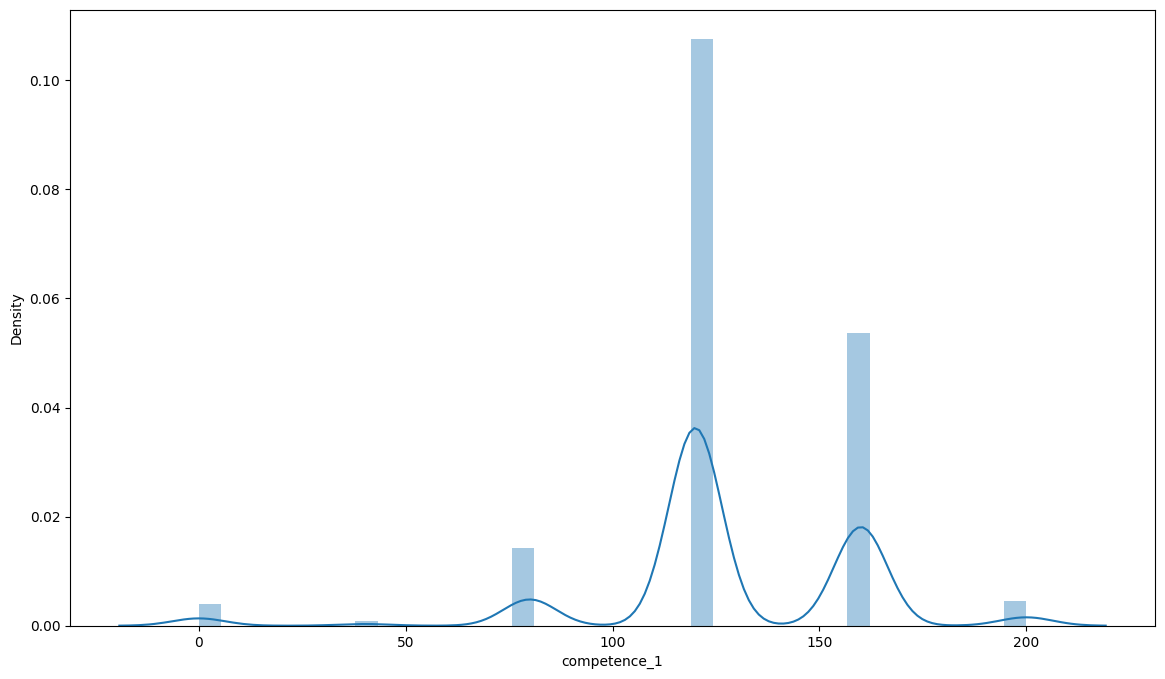

In [ ]:
plt.figure(figsize=(14, 8))
sns.distplot( aux['competence_1'] );

<ipython-input-43-e6ed4c3db849>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( aux['competence_2'] );


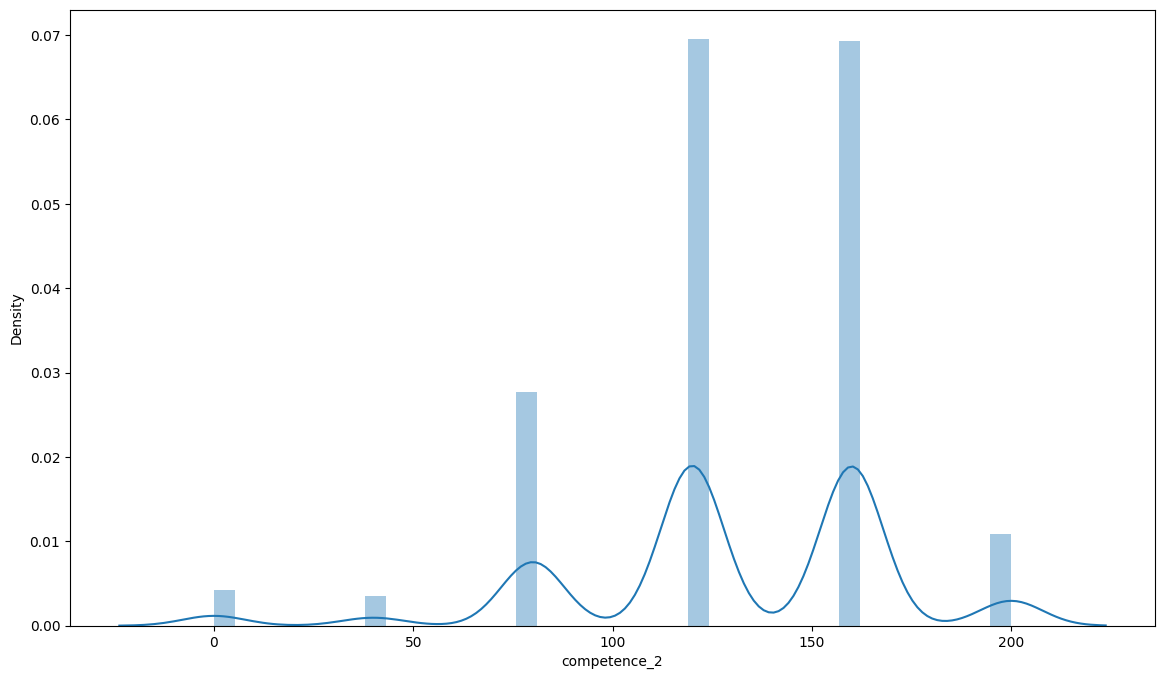

In [ ]:
plt.figure(figsize=(14, 8))
sns.distplot( aux['competence_2'] );

<ipython-input-44-e5bdeae25b02>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( aux['competence_3'] );


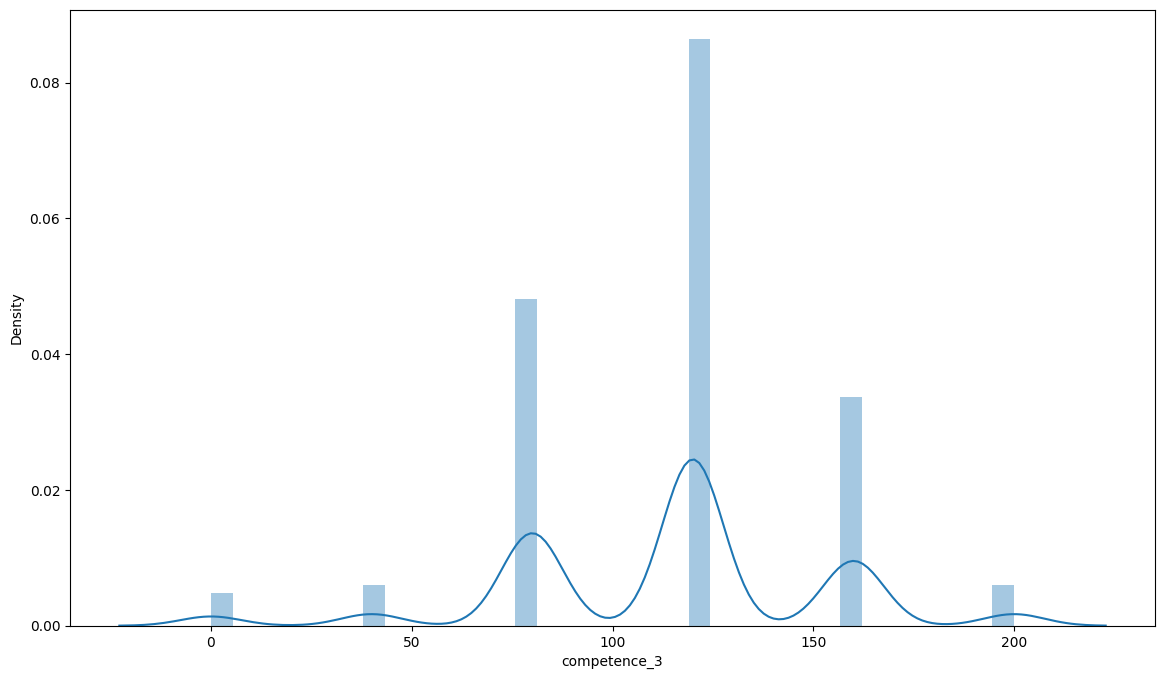

In [ ]:
plt.figure(figsize=(14, 8))
sns.distplot( aux['competence_3'] );

<ipython-input-45-5d9a16e432b9>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( aux['competence_4'] );


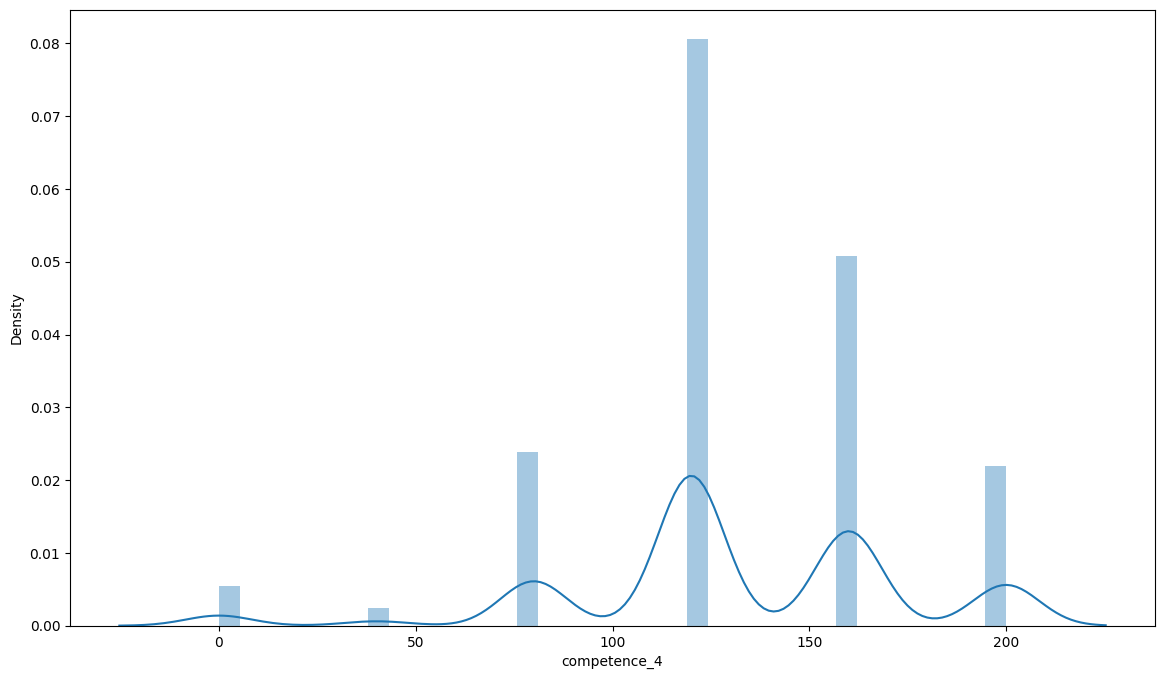

In [ ]:
plt.figure(figsize=(14, 8))
sns.distplot( aux['competence_4'] );

<ipython-input-46-7d3013a928f1>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( aux['competence_5'] );


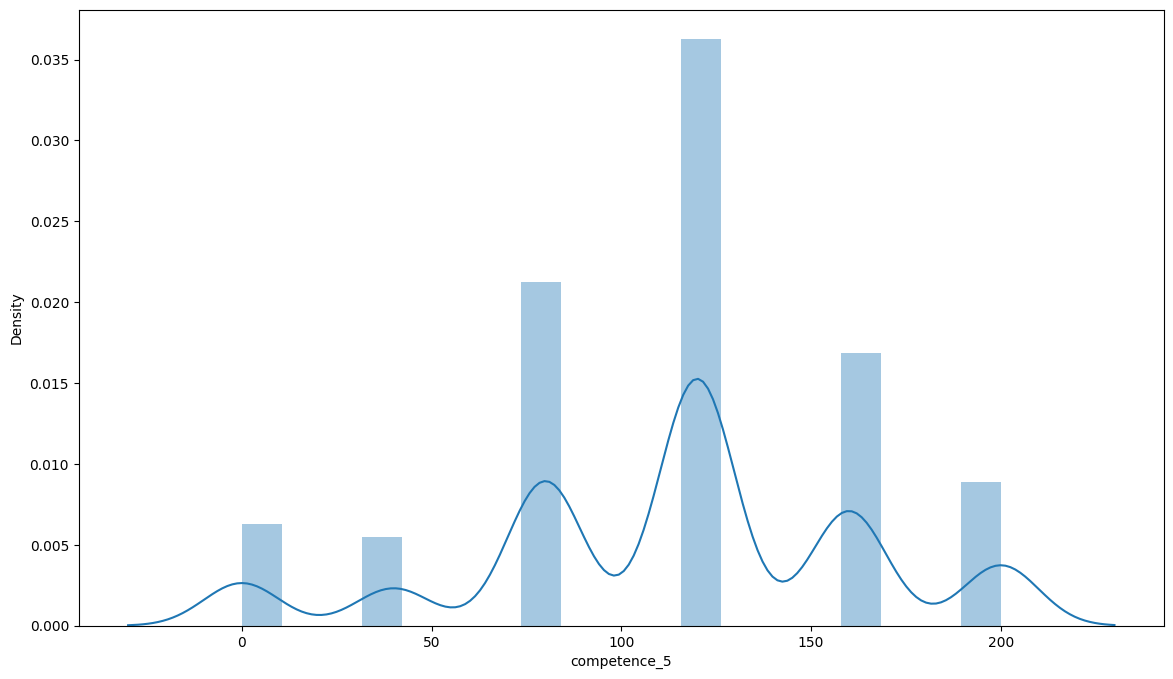

In [ ]:
plt.figure(figsize=(14, 8))
sns.distplot( aux['competence_5'] );

## Essays Tokens Analysis

#### BERT uses a subword tokenizer (WordPiece), so the maximum length corresponds to 512 subword tokens.

In [ ]:
# Join all the paragraphs of an essay in a same string
aux = all_data.copy()
aux['essay'] = aux['essay'].map( lambda x : ''.join(x))


In [ ]:
# Model Name
checkpoint = "neuralmind/bert-base-portuguese-cased"

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained( checkpoint )

def tokenize_function_aux( example ):
  return tokenizer.tokenize(
      example,
      add_special_tokens=True,
      return_attention_mask=True
  )

aux['tokens'] = aux['essay'].apply(lambda x: tokenize_function_aux(x))
aux['tokens_length'] = aux['tokens'].apply(lambda x: len(x))

In [ ]:
aux.sample(2)

,prompt,title,essay,competence,score,c1,c2,c3,c4,c5,tokens,tokens_length
3002,54,NaN,"Sarampo, caxumba e rubéola são algumas doenças...","[120, 160, 80, 120, 120]",600,120,160,80,120,120,"[[CLS], Sara, ##mp, ##o, ,, ca, ##xu, ##mba, e...",393
609,25,Em pleno século XXI,"Em pleno século XXI, no Brasil, é alto o númer...","[80, 80, 80, 80, 80]",400,80,80,80,80,80,"[[CLS], Em, pleno, século, XXI, ,, no, Brasil,...",188


### Distribuition Graph of Tokens Length per Essay

In [ ]:
"""
intervals = [0,120,240,360,480,600,720,840,1000 ]
ax = sns.histplot(data=aux, x="score", bins=intervals)
ax.set_xticks(intervals)
ax.set_xticklabels(intervals)
ax.set_title("Grades Distribution")
"""

'\nintervals = [0,120,240,360,480,600,720,840,1000 ]\nax = sns.histplot(data=aux, x="score", bins=intervals)\nax.set_xticks(intervals)\nax.set_xticklabels(intervals)\nax.set_title("Grades Distribution")\n'

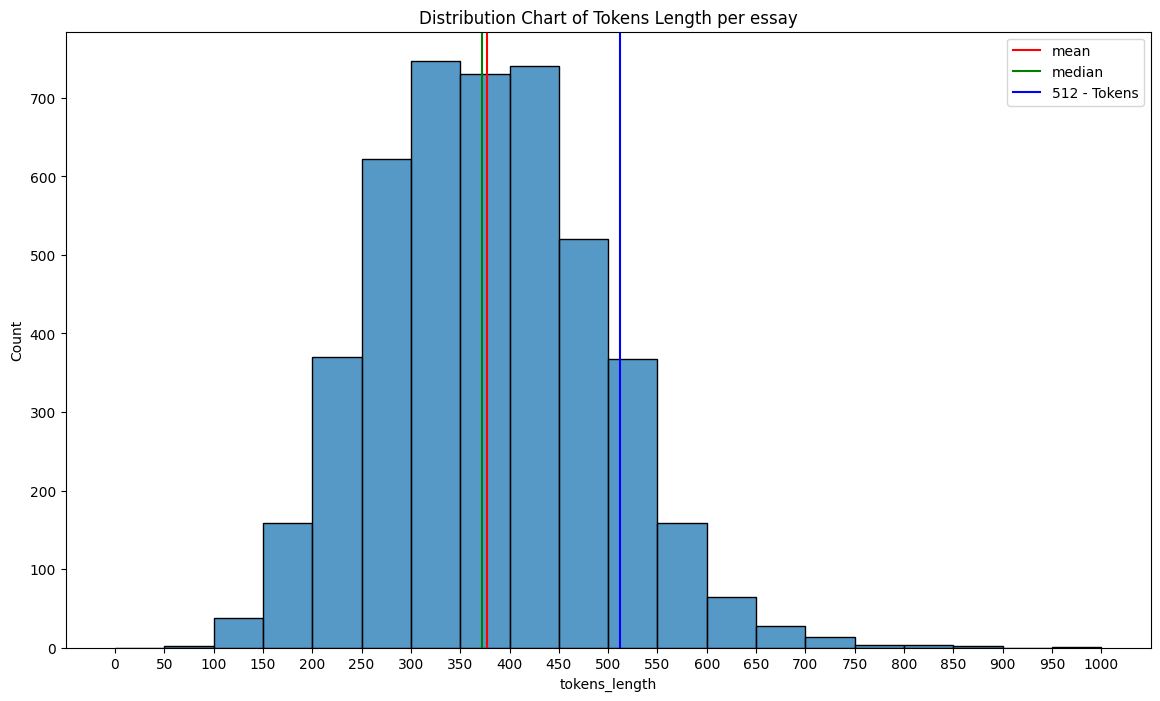

In [ ]:
plt.figure(figsize=(14, 8))

# mean in Red
plt.axvline(x=np.mean(aux['tokens_length']), ymin=0, ymax=1, label='mean', color='r')
# median in Green
plt.axvline(x=np.median(aux['tokens_length']), ymin=0, ymax=1, label='median', color='g')
# 512 tokens_length
plt.axvline(x=512, ymin=0, ymax=1, label='512 - Tokens', color='b')


#bin_midpoints = 0.5 * (intervals[:-1] + intervals[1:])
#plt.xticks([i+20 for i in intervals[:-1]], intervals[:-1], fontsize=12)

#for count, bin_start, patch in zip(n, bins[:-1], patches):
#    plt.text(bin_start + (bins[1] - bins[0]) / 2, count + 1, str(int(count)), ha='center', va='bottom', fontsize=12)




#sns.distplot( aux['tokens_length'] );
#intervals=[100,150,200,250,300,350,400,450,500,550,600,650,700,750,800,900,1000]
intervals = [(i*50) for i in range(1050//50)]
bin_midpoints = 0.5 * (intervals[:-1] + intervals[1:])


#for count, bin_start, patch in zip(n, bins[:-1], patches):
#    plt.text(bin_start + (bins[1] - bins[0]) / 2, count + 1, str(int(count)), ha='center', va='bottom', fontsize=12)


n, bins, patches = plt.hist(all_data["score"], bins=intervals, color='#3498DB', edgecolor='black')

plt.xticks([i+20 for i in intervals], intervals)


plt.xlabel('Notas')
plt.ylabel('Frequência')
plt.grid(axis='y', linestyle='--', color='gray')


#ax = sns.histplot(data=aux, x="tokens_length", bins=intervals)
ax.set_xticks(intervals)
ax.set_xticklabels(intervals)
plt.title('Distribution Chart of Tokens Length per essay')
plt.legend();


In [ ]:
all_data["tokens_length"]

KeyError: ignored

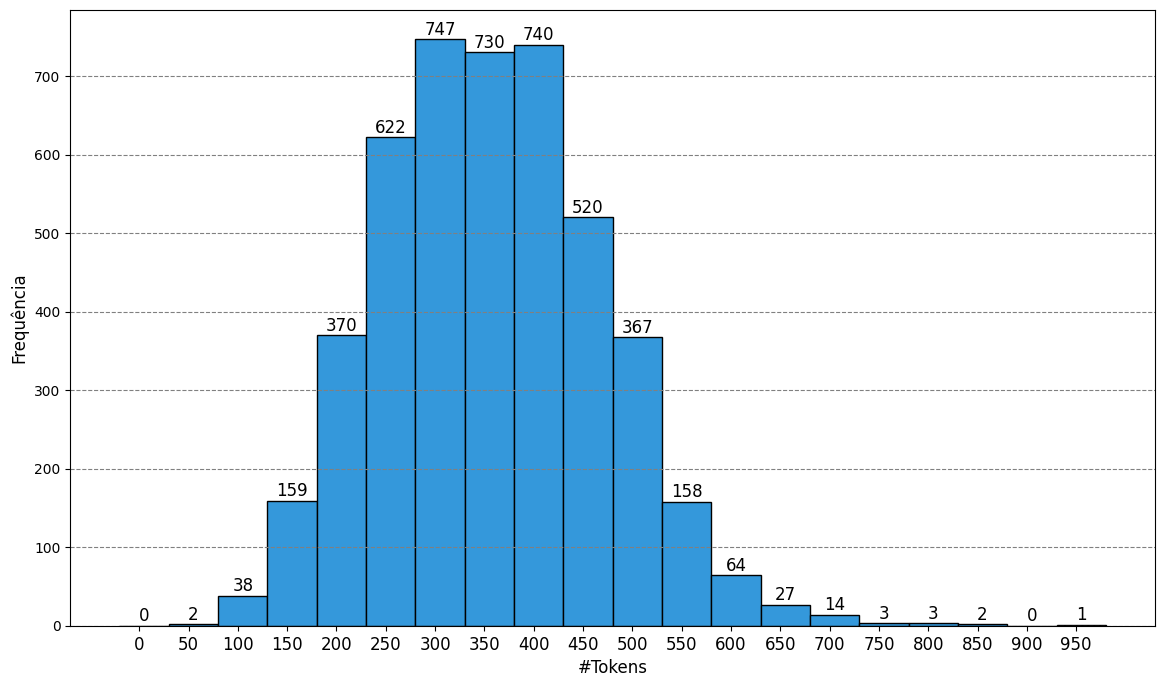

In [ ]:
plt.figure(figsize=(14, 8))

#intervals = [0,120,240,360,480,600,720,840,1000 ]
intervals = [(i*50) for i in range(1050//50)]
n, bins, patches = plt.hist(aux["tokens_length"], bins=intervals, color='#3498DB', edgecolor='black')
#bin_midpoints = 0.5 * (intervals[:-1] + intervals[1:])
plt.xticks([i+20 for i in intervals[:-1]], intervals[:-1], fontsize=12)

for count, bin_start, patch in zip(n, bins[:-1], patches):
    plt.text(bin_start + (bins[1] - bins[0]) / 2, count + 1, str(int(count)), ha='center', va='bottom', fontsize=12)

plt.xlabel('#Tokens', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.grid(axis='y', linestyle='--', color='gray')

plt.savefig('tokens_distribution.png', format='png', dpi=300)


#### As BERT uses a subword tokenizer (WordPiece), that the maximum length corresponds to 512 subword tokens, we will lose ~12% of our training dataset

In [ ]:
miss_data = len( aux[ aux['tokens_length'] > 512 ] )
print(f'Train dataset size: {aux.shape[0]}')
print(f'Miss data size: {miss_data}')
print(f'Miss data percentage: {miss_data / aux.shape[0]}')

Train dataset size: 3198
Miss data size: 375
Miss data percentage: 0.11726078799249531


## Score Essays

In [ ]:
df.score

0       440
1       480
2       440
3       640
4       560
       ... 
3193    360
3194    640
3195    600
3196    680
3197    480
Name: score, Length: 3198, dtype: int64

In [ ]:
print(f"The essays score mean is: {np.mean( df['score'] )}")
print(f"The essays score median is: {np.median( df['score'] )}")
print(f"The minimum essays score is: {np.min( df['score'] )}")
print(f"The maximum essays score is: {np.max( df['score'] )}")

The essays score mean is: 614.4965603502189
The essays score median is: 600.0
The minimum essays score is: 0
The maximum essays score is: 1000


<ipython-input-56-69ea898fe2dd>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df['score'] );


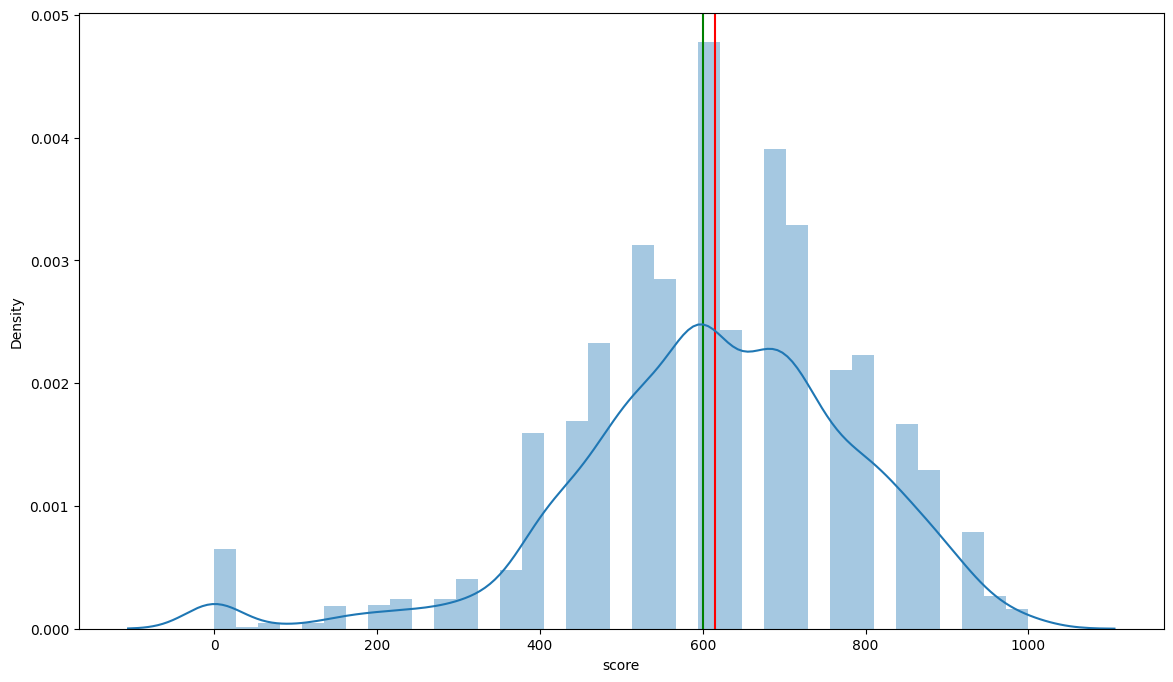

In [ ]:
plt.figure(figsize=(14, 8))

# mean in Red
plt.axvline(x=np.mean(df['score']), ymin=0, ymax=1, label='mean', color='r')
# median in Green
plt.axvline(x=np.median(df['score']), ymin=0, ymax=1, label='median', color='g')


sns.distplot( df['score'] );


# Data Preparation

In [ ]:
def data_preparation( df, y_func ):
    # Join all the paragraphs of an essay in a same string
    df['essay'] = df['essay'].map( lambda x : ''.join(x))

    df['labels'] = df['score'].apply( lambda x : y_func(x) )

    # Convert Pandas dataframe to hugging face Dataset
    df_dataset = Dataset.from_pandas( df );

    return df_dataset

# Tokenization

In [ ]:
def tokenization( df_dataset, valid_dataset, checkpoint ):
    # Tokenizer
    tokenizer = AutoTokenizer.from_pretrained(checkpoint)

    def tokenize_function(example):
        return tokenizer(example['essay'],
                        add_special_tokens=True,
                        padding='max_length',
                        truncation='longest_first',
                        max_length=512,
                        return_attention_mask=True)

    tokenized_train = df_dataset.map(tokenize_function, batched=True)

    tokenized_valid = valid_dataset.map(tokenize_function, batched=True)

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

    tf_train_dataset = tokenized_train.to_tf_dataset(
        columns=["attention_mask", "input_ids", "token_type_ids"],
        label_cols=["labels"],
        shuffle=True,
        collate_fn=data_collator,
        batch_size=8,
    )
    tf_validation_dataset = tokenized_valid.to_tf_dataset(
        columns=["attention_mask", "input_ids", "token_type_ids"],
        label_cols=["labels"],
        shuffle=False,
        collate_fn=data_collator,
        batch_size=8,
    )
    return tf_train_dataset, tf_validation_dataset

# Model Training

In [ ]:
def model_training( checkpoint, num_labels, tf_train_dataset, tf_validation_dataset, home_path, model_name):

    if num_labels == 1:
      model_type = 'regression'
    else:
      model_type = 'classification'

    # Create Model
    model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=num_labels)

    batch_size = 8
    num_epochs = 4
    # The number of training steps is the number of samples in the dataset, divided by the batch size then multiplied
    # by the total number of epochs. Note that the tf_train_dataset here is a batched tf.data.Dataset,
    # not the original Hugging Face Dataset, so its len() is already num_samples // batch_size.
    num_train_steps = len(tf_train_dataset) * num_epochs

    lr_scheduler = PolynomialDecay(
        initial_learning_rate=5e-5,
        end_learning_rate=0.0,
        decay_steps=num_train_steps
    )

    opt = Adam(learning_rate=lr_scheduler)

    if model_type == 'classification':
      loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
      metrics = ['accuracy']
    elif model_type == 'regression':
      loss = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
      metrics = [tf.keras.metrics.RootMeanSquaredError()]

    model.compile(optimizer=opt, loss=loss, metrics=metrics)

    history = model.fit(tf_train_dataset, validation_data=tf_validation_dataset, epochs=num_epochs, shuffle=False)

    # Save the model
    #pickle.dump( model, open(home_path + model_name + '.pkl', 'wb') )

    return model, history

# Metrics Functions

In [ ]:
# Metrics for Regression
def mean_absolute_percentage_error(y, yhat):
    return np.mean( np.abs( (y - yhat) / y ) )

def ml_error_regression( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat) )
    #return ( 0 if x < 500 else 2 if (x >= 700) else 1 )
    #[0 if i < 500 else 2 if (i >= 700) else 1]
    #[1 if i > 500 else 0 for i in y],
    #[1 if i > 500 else 0 for i in yhat],
    cohen_2 = cohen_kappa_score(
        [1 if i > 500 else 0 for i in y],
        [1 if i > 500 else 0 for i in yhat],
         weights='quadratic')

    cohen_3 = cohen_kappa_score(
        [0 if i < 500 else 2 if (i >= 700) else 1 for i in y],
        [0 if i < 500 else 2 if (i >= 700) else 1 for i in yhat],
         weights='quadratic')

    return pd.DataFrame( { 'Model Name': model_name,
                           'MAE': mae,
                           'MAPE': mape,
                           'RMSE': rmse,
                           'COHEN2': cohen_2,
                           'COHEN3': cohen_3 }, index=[0])

In [ ]:
# Metrics for Classification
def accuracy(y, yhat):
    hits = 0
    for i in range(len(y)):
        hits = hits + int(y[i] == yhat[i])
    return hits / len(y)

def calc_f1_score(y, yhat):
    tp = fp = fn = 0
    for i in range(len(y)):
        # true positive
        if (y[i] == 1) and (yhat[i] == 1) :
            tp = tp + 1
        # false positive
        elif (y[i] == 0) and (yhat[i] == 1) :
            fp = fp + 1
        # false negative
        elif (y[i] == 1) and (yhat[i] == 0) :
            fn = fn + 1

    if (tp + fp) > 0 :
        precision = tp / (tp + fp)
    else:
        precision = 0

    if (tp + fn) > 0 :
        recall = tp / (tp + fn)
    else:
        recall = 0

    if (precision + recall) > 0 :
        f1_score = 2*precision*recall / (precision + recall)
    else:
        f1_score = 0

    return f1_score

def ml_error_classification( model_name, y, yhat ):
    acc = accuracy( y, yhat )
    f1_score = calc_f1_score( y, yhat )
    cohen = cohen_kappa_score(y, yhat, weights='quadratic')

    return pd.DataFrame( { 'Model Name': model_name,
                           'Accuracy': acc,
                           'F1-Score': f1_score ,
                           'Cohen Kappa Score': cohen,
                          }, index=[0] )

# Evaluation

In [ ]:
def model_evaluation( model, model_type, x_data, y, y_func ):
  # Get the logits from the prediction
  preds = model.predict(x_data)["logits"]

  # Use Sigmoid to transform logits in the range [0,1]
  if( model_type == 'classification' ):
    maxlogits = np.argmax(preds, axis=1)
    #z = 1/(1 + np.exp(-maxlogits))
    y_hat = maxlogits
    eval = ml_error_classification('NN', y, y_hat)
  elif( model_type == 'regression'):
    maxlogits = np.max(preds, axis=1)
    y_hat = (maxlogits * 1000).astype(int)
    y = y * 1000
    eval = ml_error_regression('NN', y, y_hat)

  return eval, preds, y_hat

# Pipeline

In [ ]:
home_path = '/content/drive/MyDrive/TCC/'

# Load data
train, valid, test = load_data()

df = train.copy()

# Y LABEL
# 2 Labels - return ( 1 if x > 500 else 0 )
# 3 Labels - return ( 0 if x < 500 else 2 if (x >= 700) else 1 )
#def y_func(x): return ( 1 if x > 500 else 0 )
#def y_func(x): return x / 1000  # Regression
def y_func(x): return ( 0 if x <= 560 else 2 if (x > 680) else 1 )
#def y_func(x): return (0 if x < 520 else 1 if (x >= 520) and (x <= 600) else 3 if x > 720 else 2)
#def y_func(x): return (0 if x < 480 else 1 if (x >= 480) and (x < 600) else 2 if (x >= 600) and (x < 680) else 4 if x >= 760 else 3)



# Data preparation
n_labels = 3
df_dataset = data_preparation( df=df, y_func=y_func )
valid_dataset = data_preparation( df=valid, y_func=y_func )

# Model Name
checkpoint = "neuralmind/bert-base-portuguese-cased"

# Tokenization
tf_train_dataset, tf_validation_dataset = tokenization( df_dataset, valid_dataset, checkpoint)

# Training Model
model, history = model_training( checkpoint, n_labels, tf_train_dataset, tf_validation_dataset, home_path, 'model_teste7' )

Train shape: (3198, 5)
Validation shape: (686, 5)
Test shape: (686, 5)


Map:   0%|          | 0/3198 [00:00<?, ? examples/s]

Map:   0%|          | 0/686 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:400: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier', 'bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
400/400 [==============================] - 486s 1s/step - loss: 0.8731 - accuracy: 0.5794 - val_loss: 0.8209 - val_accuracy: 0.6283
Epoch 2/4
400/400 [==============================] - 428s 1s/step - loss: 0.6309 - accuracy: 0.7233 - val_loss: 0.7496 - val_accuracy: 0.6808
Epoch 3/4
400/400 [==============================] - 415s 1s/step - loss: 0.3517 - accuracy: 0.8602 - val_loss: 0.9265 - val_accuracy: 0.6414
Epoch 4/4
400/400 [==============================] - 428s 1s/step - loss: 0.1246 - accuracy: 0.9669 - val_loss: 1.2004 - val_accuracy: 0.6618


In [ ]:
model.save_pretrained('fine_tuned_bert_regression')

In [ ]:
#model_aux = TFAutoModelForSequenceClassification.from_pretrained("./fine_tuned_bert/")


In [ ]:
#pickle.dump( model, open(home_path + 'enem_auto_correction_model' + '.pkl', 'wb') )


# Evaluate

In [ ]:
# Evaluation Training
model_type = "classification"
resul, preds, y_hat = model_evaluation(model=model, model_type=model_type, x_data=tf_train_dataset, y=df['labels'], y_func=y_func)

400/400 [==============================] - 136s 334ms/step


In [ ]:
resul

,Model Name,MAE,MAPE,RMSE,COHEN2,COHEN3
0,NN,201.403064,inf,259.79586,-0.042095,-0.032778


In [ ]:
# Evaluation Validation
model_type = "classification"
resul, preds, y_hat = model_evaluation(model=model, model_type=model_type, x_data=tf_validation_dataset, y=valid['labels'], y_func=y_func)

86/86 [==============================] - 29s 333ms/step


In [ ]:
resul

,Model Name,MAE,MAPE,RMSE,COHEN2,COHEN3
0,NN,96.40379,inf,133.253452,0.490731,0.61845


In [ ]:
history

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
"""

SyntaxError: ignored

In [ ]:

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Teste shuffle true

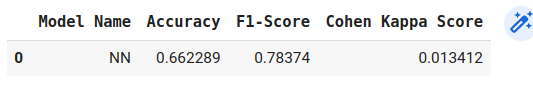

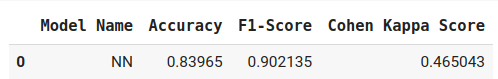

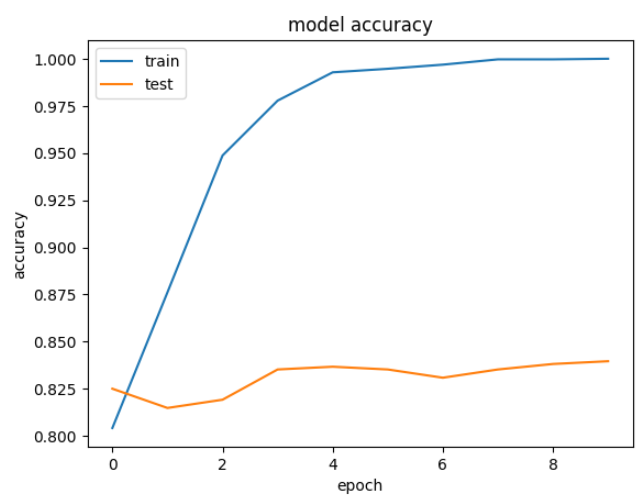

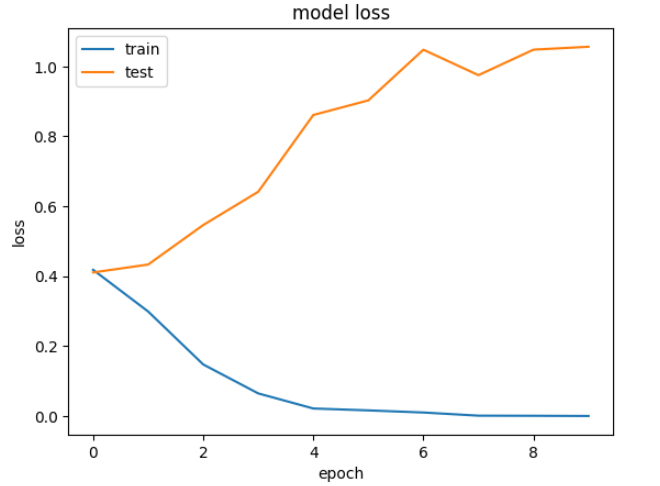

### TESTE 1:

**MODEL NAME:**

**TOKENIZER**

padding='max_length',
truncation='longest_first',
max_length=200,


**MODEL**

batch_size = 8,
num_epochs = 1

**Y - LABEL**

  2 CLASSES ( 1 if x > 500 else 0 )

**ACCURACY (VAL)**: 0.8

### TESTE 2:

**MODEL NAME**: Teste 2


**TOKENIZER**

padding='max_length',
truncation='longest_first',
max_length=512,


**MODEL**

batch_size = 8,
num_epochs = 1

**Y - LABEL**

  2 CLASSES ( 1 if x > 500 else 0 )

**ACCURACY (VAL)**: 0.77551

**F1-Score (VAL)**: 0.872727


### TESTE 3:

**MODEL NAME**: Teste 3

**TOKENIZER**

padding='max_length',
truncation='longest_first',
max_length=512,


**MODEL**

batch_size = 8,
num_epochs = 1

**Y - LABEL**

  3 CLASSES ( 0 if x < 500 else 2 if (x >= 700) else 1 )

**ACCURACY (VAL)**: 0.672012

**F1-Score (VAL)**: 0.814545

**Cohen Kappa Score (VAL)**: 0.623306

### TESTE 3.2:

**MODEL NAME**: Teste 3.2

**TOKENIZER**

padding='max_length',
truncation='longest_first',
max_length=512,


**MODEL**

batch_size = 8,
num_epochs = 5

**Y - LABEL**

  3 CLASSES ( 0 if x < 500 else 2 if (x >= 700) else 1 )

**ACCURACY (VAL)**: 0.695335

**F1-Score (VAL)**: 0.830372

**Cohen Kappa Score (VAL)**: 0.634065

Model Name	Accuracy	F1-Score	Cohen Kappa Score
0	NN	0.695335	0.830372	0.634065

### TESTE 4:

**MODEL NAME**:

**TOKENIZER**

padding='max_length',
truncation='longest_first',
max_length=512,


**MODEL**

batch_size = 8,
num_epochs = 10

**Y - LABEL**

  3 CLASSES ( 0 if x < 500 else 2 if (x >= 700) else 1 )

**ACCURACY (VAL)**: 0.663265

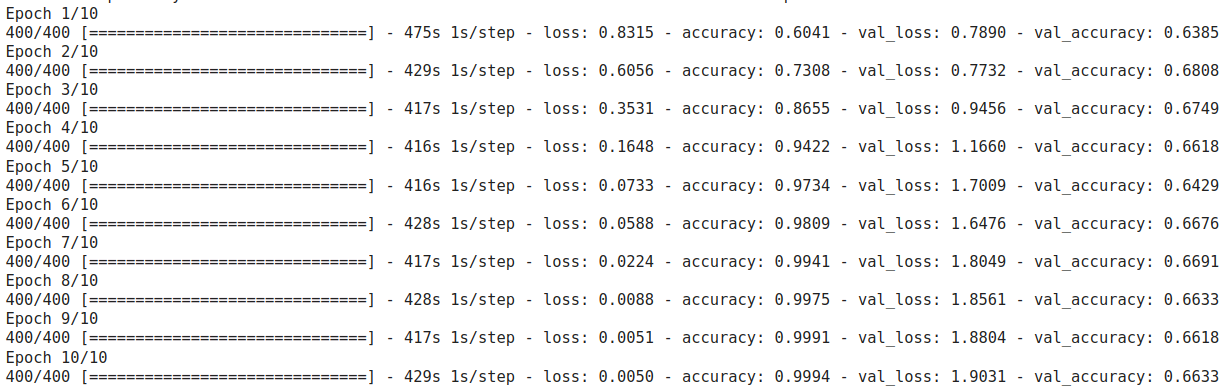

### TESTE 5: Regression

**MODEL NAME**:

**TOKENIZER**

padding='max_length',
truncation='longest_first',
max_length=512,

**MODEL**

batch_size = 8,
num_epochs = 1

**Y - LABEL**

  2 CLASSES ( 1 if x > 500 else 0 ) - For Cohen Kappa

**MAE (VAL)**: 94.253965

**RMSE (VAL)**: 132.205519

**COHEN (VAL)**: 0.466807

### TESTE 6: Regression

**MODEL NAME**:

**TOKENIZER**

padding='max_length',
truncation='longest_first',
max_length=512,

**MODEL**

batch_size = 8,
num_epochs = 5

**Y - LABEL**

  2 CLASSES ( 1 if x > 500 else 0 ) - For Cohen Kappa
  
  3 CLASSES ( 0 if x < 500 else 2 if (x >= 700) else 1 )

**MAE (VAL)**: 92.024781

**RMSE (VAL)**: 132.027247

**COHEN (VAL) 2 classes**: 0.519832

**COHEN (VAL) 3 classes**: 0.639106


### TESTE 7: Classification - Tercile Model

**MODEL NAME**: Tercile Model

**TOKENIZER**

padding='max_length',
truncation='longest_first',
max_length=512,

**MODEL**

batch_size = 8,
num_epochs = 4

**Y - LABEL**
  
  3 CLASSES ( 0 if x <= 560 else 2 if (x > 680) else 1 )

**Accuracy (VAL)**: 0.648688

**COHEN (VAL) 3 classes**: 0.644643



### TESTE 8: Classification - Quartile Model

**MODEL NAME**: Quartile Model

**TOKENIZER**

padding='max_length',
truncation='longest_first',
max_length=512,

**MODEL**

batch_size = 8,
num_epochs = 4

**Y - LABEL**
  
  4 CLASSES
  
  (0 if x < 520 else 1 if (x >= 520) and (x <= 600) else 3 if x > 720 else 2)

**Accuracy (VAL)**: 0.533528

**COHEN (VAL) 4 classes**: 0.67821

### TESTE 10: Classification - Quintile Model

**MODEL NAME**: Quintile Model

**TOKENIZER**

padding='max_length',
truncation='longest_first',
max_length=512,

**MODEL**

batch_size = 8,
num_epochs = 4

**Y - LABEL**
  
  5 CLASSES
  
return (0 if x < 480 else 1 if (x >= 480) and (x < 600) else 2 if (x >= 600) and (x < 680) else 4 if x >= 760 else 3)

**Accuracy (VAL)**: 0.475219

**COHEN (VAL) 5 classes**: 0.705709

### TESTE 9: Classification - Quintile Model

**MODEL NAME**: Quintile Model

**TOKENIZER**

padding='max_length',
truncation='longest_first',
max_length=512,

**MODEL**

batch_size = 8,
num_epochs = 6

**Y - LABEL**
  
  5 CLASSES
  
return (0 if x < 480 else 1 if (x >= 480) and (x < 600) else 2 if (x >= 600) and (x < 680) else 4 if x >= 760 else 3)

**Accuracy (VAL)**: 0.453353

**COHEN (VAL) 5 classes**: 0.683343

In [ ]:
# Calculate MAE
#print(f"The MAE is: {np.mean( np.abs(valid['scorePredict'] - valid['score']) )}")


In [ ]:
"""
aux = valid[['score', 'scorePredict']].sort_values(by='score')
plt.figure(figsize=(16, 10))
plt.plot(np.linspace(0,685, 686), aux['score']);
plt.plot(np.linspace(0,685, 686), aux['scorePredict']);
"""

"\naux = valid[['score', 'scorePredict']].sort_values(by='score')\nplt.figure(figsize=(16, 10))\nplt.plot(np.linspace(0,685, 686), aux['score']);\nplt.plot(np.linspace(0,685, 686), aux['scorePredict']);\n"

In [ ]:
"""
nIntervals = 20
intervalScore = []
indexInterval = []

for i in range(nIntervals):
  init = i * (1000 // nIntervals)
  end = (i+1) * (1000 // nIntervals)
  indexInterval.append( i* )
  intervalScore.append( np.mean( aux[ (aux['score'] > init) & (aux['score'] < end) ]['scorePredict'] ) )

intervalScore

plt.figure(figsize=(16, 10))
plt.plot(np.linspace(0,685, 686), aux['score']);
plt.plot(indexInterval, intervalScore);
"""

"\nnIntervals = 20\nintervalScore = []\nindexInterval = []\n\nfor i in range(nIntervals):\n  init = i * (1000 // nIntervals)\n  end = (i+1) * (1000 // nIntervals)\n  indexInterval.append( i* )\n  intervalScore.append( np.mean( aux[ (aux['score'] > init) & (aux['score'] < end) ]['scorePredict'] ) )\n\nintervalScore\n\nplt.figure(figsize=(16, 10))\nplt.plot(np.linspace(0,685, 686), aux['score']);\nplt.plot(indexInterval, intervalScore);\n"

In [ ]:
"""
aux = valid[['score', 'scorePredict']].sort_values(by='scorePredict')
plt.plot(np.linspace(0,685, 686), aux['score']);
plt.plot(np.linspace(0,685, 686), aux['scorePredict']);
"""


"\naux = valid[['score', 'scorePredict']].sort_values(by='scorePredict')\nplt.plot(np.linspace(0,685, 686), aux['score']);\nplt.plot(np.linspace(0,685, 686), aux['scorePredict']);\n"

In [ ]:
aux

,prompt,title,essay,competence,score,tokens,tokens_length
0,60,Reforma da previdência,É notório que a reforma da previdência no Bras...,"[120, 80, 80, 120, 40]",440,"[[CLS], É, no, ##tório, que, a, reforma, da, p...",182
1,51,ANALFABETISMO E SOCIEDADE,"Pode -se afirmar que a presença dos Jesuítas, ...","[120, 120, 80, 80, 80]",480,"[[CLS], Pode, -, se, afirmar, que, a, presença...",241
2,73,Caminhos para superar os desafios encontrados ...,Em 13 de maio de 1888 veio ao Brasil a lei da ...,"[120, 80, 80, 80, 80]",440,"[[CLS], Em, 13, de, maio, de, 188, ##8, veio, ...",207
3,51,Analfabetismo funcional no Brasil tem solução.,“Uma sociedade só progride quando um se mobili...,"[120, 160, 120, 120, 120]",640,"[[CLS], “, Uma, sociedade, só, prog, ##rid, ##...",373
4,59,NaN,"Nas últimas décadas, o Brasil vem enfrentando ...","[120, 120, 80, 120, 120]",560,"[[CLS], Nas, últimas, décadas, ,, o, Brasil, v...",253
...,...,...,...,...,...,...,...
3193,49,O papel dos Influenciadores digitais,Atualmente a influência que a mídia proporcion...,"[120, 80, 80, 80, 0]",360,"[[CLS], Atualmente, a, influência, que, a, míd...",206
3194,73,O tempo não cura tudo.,É mais fácil desintegrar um átomo do que um pr...,"[120, 160, 120, 120, 120]",640,"[[CLS], É, mais, fácil, des, ##integra, ##r, u...",355
3195,69,NaN,É indiscutível que o uso de agrotóxicos no Bra...,"[120, 120, 120, 120, 120]",600,"[[CLS], É, indis, ##cu, ##tível, que, o, uso, ...",297
3196,59,Crise Econômica e Corrupção,De acordo com o relatório internacional divulg...,"[120, 160, 120, 160, 120]",680,"[[CLS], De, acordo, com, o, relatório, interna...",545


# Evaluating

In [ ]:
"""
import evaluate

metric = evaluate.load("glue", "mrpc")
metric.compute(predictions=class_preds, references=raw_datasets["validation"]["label"])
"""

'\nimport evaluate\n\nmetric = evaluate.load("glue", "mrpc")\nmetric.compute(predictions=class_preds, references=raw_datasets["validation"]["label"])\n'

In [ ]:
essay_str = 'É notório que a reforma da previdência no Brasil traz divergências de opiniões, especialmente em relação aos políticos.Dentre tantos motivos relevantes temos aspectos favoráveis e desfavoráveis a este fato: a economia do governo por um lado como fator favorável e o aumento do tempo de trabalho para que o povo consiga se aposentar por outro.Sabe-se que o congresso nacional está dividido com relação ao assunto; e a população também. Embora os benefícios da reforma tenham sido exaustivamente frisados nos discursos da bancada governista, a oposição não ainda não foi convencida.Colocando-se na balança os prós e os contras parece que ainda haverá um longo caminho a ser percorrido até que haja um consenso com relação à reforma da previdência. Portanto, o país terá de esperar, e muito, para saber se a reforma é o melhor para o Brasil ou apenas mais uma dor de cabeça.'

df = pd.DataFrame(data={'essay': essay_str}, index=[0])

df

,essay
0,É notório que a reforma da previdência no Bras...


In [ ]:
import json
essay_str = "É notório que a reforma da previdência no Brasil traz divergências de opiniões, especialmente em relação aos políticos.Dentre tantos motivos relevantes temos aspectos favoráveis e desfavoráveis a este fato: a economia do governo por um lado como fator favorável e o aumento do tempo de trabalho para que o povo consiga se aposentar por outro.Sabe-se que o congresso nacional está dividido com relação ao assunto; e a população também. Embora os benefícios da reforma tenham sido exaustivamente frisados nos discursos da bancada governista, a oposição não ainda não foi convencida.Colocando-se na balança os prós e os contras parece que ainda haverá um longo caminho a ser percorrido até que haja um consenso com relação à reforma da previdência. Portanto, o país terá de esperar, e muito, para saber se a reforma é o melhor para o Brasil ou apenas mais uma dor de cabeça."
df = pd.DataFrame(data={'essay': essay_str}, index=[0])
#data = json.dumps({'essay': essay_str})
data = json.dumps(df.to_dict(orient='records'))

data

'[{"essay": "\\u00c9 not\\u00f3rio que a reforma da previd\\u00eancia no Brasil traz diverg\\u00eancias de opini\\u00f5es, especialmente em rela\\u00e7\\u00e3o aos pol\\u00edticos.Dentre tantos motivos relevantes temos aspectos favor\\u00e1veis e desfavor\\u00e1veis a este fato: a economia do governo por um lado como fator favor\\u00e1vel e o aumento do tempo de trabalho para que o povo consiga se aposentar por outro.Sabe-se que o congresso nacional est\\u00e1 dividido com rela\\u00e7\\u00e3o ao assunto; e a popula\\u00e7\\u00e3o tamb\\u00e9m. Embora os benef\\u00edcios da reforma tenham sido exaustivamente frisados nos discursos da bancada governista, a oposi\\u00e7\\u00e3o n\\u00e3o ainda n\\u00e3o foi convencida.Colocando-se na balan\\u00e7a os pr\\u00f3s e os contras parece que ainda haver\\u00e1 um longo caminho a ser percorrido at\\u00e9 que haja um consenso com rela\\u00e7\\u00e3o \\u00e0 reforma da previd\\u00eancia. Portanto, o pa\\u00eds ter\\u00e1 de esperar, e muito, para s

In [ ]:
data

'[{"essay": "\\u00c9 not\\u00f3rio que a reforma da previd\\u00eancia no Brasil traz diverg\\u00eancias de opini\\u00f5es, especialmente em rela\\u00e7\\u00e3o aos pol\\u00edticos.Dentre tantos motivos relevantes temos aspectos favor\\u00e1veis e desfavor\\u00e1veis a este fato: a economia do governo por um lado como fator favor\\u00e1vel e o aumento do tempo de trabalho para que o povo consiga se aposentar por outro.Sabe-se que o congresso nacional est\\u00e1 dividido com rela\\u00e7\\u00e3o ao assunto; e a popula\\u00e7\\u00e3o tamb\\u00e9m. Embora os benef\\u00edcios da reforma tenham sido exaustivamente frisados nos discursos da bancada governista, a oposi\\u00e7\\u00e3o n\\u00e3o ainda n\\u00e3o foi convencida.Colocando-se na balan\\u00e7a os pr\\u00f3s e os contras parece que ainda haver\\u00e1 um longo caminho a ser percorrido at\\u00e9 que haja um consenso com rela\\u00e7\\u00e3o \\u00e0 reforma da previd\\u00eancia. Portanto, o pa\\u00eds ter\\u00e1 de esperar, e muito, para s

In [ ]:
pd.DataFrame(data, index=[0])

ValueError: ignored

In [ ]:
essay_str = 'É notório que a reforma da previdência no Brasil traz divergências de opiniões, especialmente em relação aos políticos.Dentre tantos motivos relevantes temos aspectos favoráveis e desfavoráveis a este fato: a economia do governo por um lado como fator favorável e o aumento do tempo de trabalho para que o povo consiga se aposentar por outro.Sabe-se que o congresso nacional está dividido com relação ao assunto; e a população também. Embora os benefícios da reforma tenham sido exaustivamente frisados nos discursos da bancada governista, a oposição não ainda não foi convencida.Colocando-se na balança os prós e os contras parece que ainda haverá um longo caminho a ser percorrido até que haja um consenso com relação à reforma da previdência. Portanto, o país terá de esperar, e muito, para saber se a reforma é o melhor para o Brasil ou apenas mais uma dor de cabeça.'

    df = pd.DataFrame(data={'essay': essay_str}, index=[0])

    #data = json.dumps(df.to_dict(orient='records'))
    data = json.dumps({'essay': essay_str})

In [ ]:
pd.DataFrame( aux[['title', 'essay']].loc[0].transpose() )

In [ ]:
df = pd.DataFrame(data={'essay': essay_str}, index=[0])

In [ ]:
json.dumps(df.to_dict(orient='records'))

In [ ]:
test_data = json.dumps( df.to_dict(orient='records') )

In [ ]:
isinstance(test_data, dict)

In [ ]:
pd.DataFrame(test_data, columns=test_data[0].keys())

In [ ]:
data = json.dumps({'essay': essay_str})


In [ ]:
data

In [ ]:
data[0]

In [ ]:
pd.DataFrame(data)
